# Detección de genomas anómalos de SARS-CoV-2 por medio de algoritmos de aprendizaje no supervisados 

# Distancias y Entropía

Después de obtener el conjunto de datos, se lleva a cabo el cálculo de las distancias y la entropía mencionadas en el documento de tesis. Primeramente, se obtiene la distancia entre cada genoma del virus y el genoma humano obtenido de [aqui](https://www.kazusa.or.jp/codon/cgi-bin/showcodon.cgi?species=9606). Específicamente, se emplean tanto la \textit{distancia euclidiana} como la \textit{distancia de Wasserstein} para comparar los usos de codones de ambos genomas. Los resultados se presentan una dataframe.

## ➤ Bibliotecas necesarias y configuración inicial

In [1]:
from IPython.display import display
from ipywidgets import widgets, interact
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial.distance import euclidean, cityblock, cdist
from scipy.stats import wasserstein_distance, entropy, pearsonr, spearmanr
from scipy.stats.mstats import gmean
from sklearn.cluster import KMeans

Configuración para el estilo a utilizar en las gráficas.

In [2]:
BACK = 'white'
FRONT = (230/255,236/255,245/255)

plt.rc('figure', facecolor=BACK, edgecolor='white')
plt.rc('axes', facecolor=FRONT, edgecolor='white', labelsize=14, labelweight='medium', titlesize=18, grid=True, axisbelow=True)
plt.rc('grid', color='white')

pd.set_option('display.max_rows', 6)
pd.set_option('display.max_columns', 11)

---

## ➤ Obtención de los datos a trabajar

Se obtiene el conjunto de datos de todos los genomas secuenciados de SARS-CoV-2, previamente pre-procesados.

In [3]:
dataset = pd.read_csv('Archivos/mex_genomes.csv', parse_dates=['Date'])
# Nombres de columnas de codones
codons = [str(i) for i in range(64)]
dataset

,Date,Virus,State,Description,0,...,61,62,63,Errors,Codons
0,2020-01-01,EPI_ISL_913918,Oaxaca,OAX-InDRE_114,0.035689,...,0.013952,0.019816,0.033667,9,9891
1,2020-01-01,EPI_ISL_914878,Tamaulipas,TAM-InDRE_125,0.035963,...,0.014042,0.019699,0.033842,1,9899
2,2020-01-01,EPI_ISL_933664,Estado de Mexico,MEX-InDRE_187,0.035869,...,0.013944,0.019905,0.033849,3,9897
...,...,...,...,...,...,...,...,...,...,...,...
51319,2022-06-15,EPI_ISL_13454152,Ciudad de México,CMX_InDRE_FD13769_E_S13666,0.036473,...,0.014122,0.019811,0.034034,43,9843
51320,2022-06-16,EPI_ISL_13454153,Ciudad de México,CMX_InDRE_FD13789_E_S13667,0.036329,...,0.014066,0.019632,0.033900,1,9882
51321,2022-06-16,EPI_ISL_13454154,Ciudad de México,CMX_InDRE_FD13793_E_S13668,0.036310,...,0.013857,0.019723,0.034287,1,9887


Se obtiene el uso de codones del humano

In [4]:
# Se obtiene el uso de codones del humano
humanCodons = pd.read_csv('Archivos/human_codon_usage.csv').squeeze()
humanCodons = humanCodons.rename(index={i:f'{i}' for i in humanCodons.index})
# Entropía de la distribución del uso de codones del ser humano.
humanEntropy = entropy(humanCodons, base=2)
print(f'\nEntropy: {humanEntropy:.5}\n')


Entropy: 5.7922



In [5]:
# Funcion para realizar la transformación log-cociente
def clr_transform(data):
    data = data.replace(0,0.0001)
    mg = data.apply(lambda row: gmean(row), axis=1)
    return np.log(data.divide(mg, axis=0))

### • Obtención de medidas a trabajar

Se obtiene la distancia del uso de codones del humano y la entropía de cada virus.

In [6]:
# Se obtienen la descripción de cada uso de codones
stats = dataset.select_dtypes(include=['object','datetime64'])
# Se calculan las medidas
data = dataset[codons]
stats['Human_Euclidean'] = (data
                            .apply(lambda row: euclidean(row,humanCodons), axis=1))
stats['Human_Wasserstein'] = (data
                            .apply(lambda row: wasserstein_distance(np.arange(64), np.arange(64), row,humanCodons), axis=1))
stats['Entropy'] = entropy(data, base=2, axis=1)
# Se aplica la transformacion log-cociente al conjutno de datos y se calcula la distancia esperada
data_clr = clr_transform(data)
stats['Mean_Logratio_dist'] =  cdist(data_clr,data_clr).mean(axis=1)
# Se obtienen las medidas globales
stats['Errors'] = dataset['Errors']
stats['Codons'] = dataset['Codons']
stats.to_csv('Archivos/codon_usage_stats.csv', index=False)
stats

,Date,Virus,State,Description,Human_Euclidean,Human_Wasserstein,Entropy,Mean_Logratio_dist,Errors,Codons
0,2020-01-01,EPI_ISL_913918,Oaxaca,OAX-InDRE_114,0.095266,2.415117,5.658083,0.204594,9,9891
1,2020-01-01,EPI_ISL_914878,Tamaulipas,TAM-InDRE_125,0.095288,2.422777,5.657209,0.196124,1,9899
2,2020-01-01,EPI_ISL_933664,Estado de Mexico,MEX-InDRE_187,0.095266,2.427153,5.657930,0.200951,3,9897
...,...,...,...,...,...,...,...,...,...,...
51319,2022-06-15,EPI_ISL_13454152,Ciudad de México,CMX_InDRE_FD13769_E_S13666,0.095346,2.442552,5.657989,0.233457,43,9843
51320,2022-06-16,EPI_ISL_13454153,Ciudad de México,CMX_InDRE_FD13789_E_S13667,0.095309,2.424662,5.657191,0.241662,1,9882
51321,2022-06-16,EPI_ISL_13454154,Ciudad de México,CMX_InDRE_FD13793_E_S13668,0.095365,2.432371,5.657354,0.233939,1,9887


---

## ➤ Diferencias por región geográfica

### • Distancias y entropía según el estado de procedencia del virus secuenciado.

Los resultados del dataframe se presentaron de acuerdo a la región geográfica. La siguiete figura muestra estas medidas según su estado de procedencia. 

In [9]:
# Funcion general para obtener las gráficas.
def plot_state(*, data, y, color, ax, title, ylabel):
    data.plot.scatter(x='State', y=y, color=color, s=80, ax=ax, rot=90, 
                      fontsize=14, alpha=0.5);
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(title, pad=10, fontdict=dict(size=16,weight='bold'));
    ax.set_xlabel('', fontdict=dict(size=15, weight='bold'))
    ax.set_ylabel(ylabel, fontdict=dict(size=15, weight='bold'))

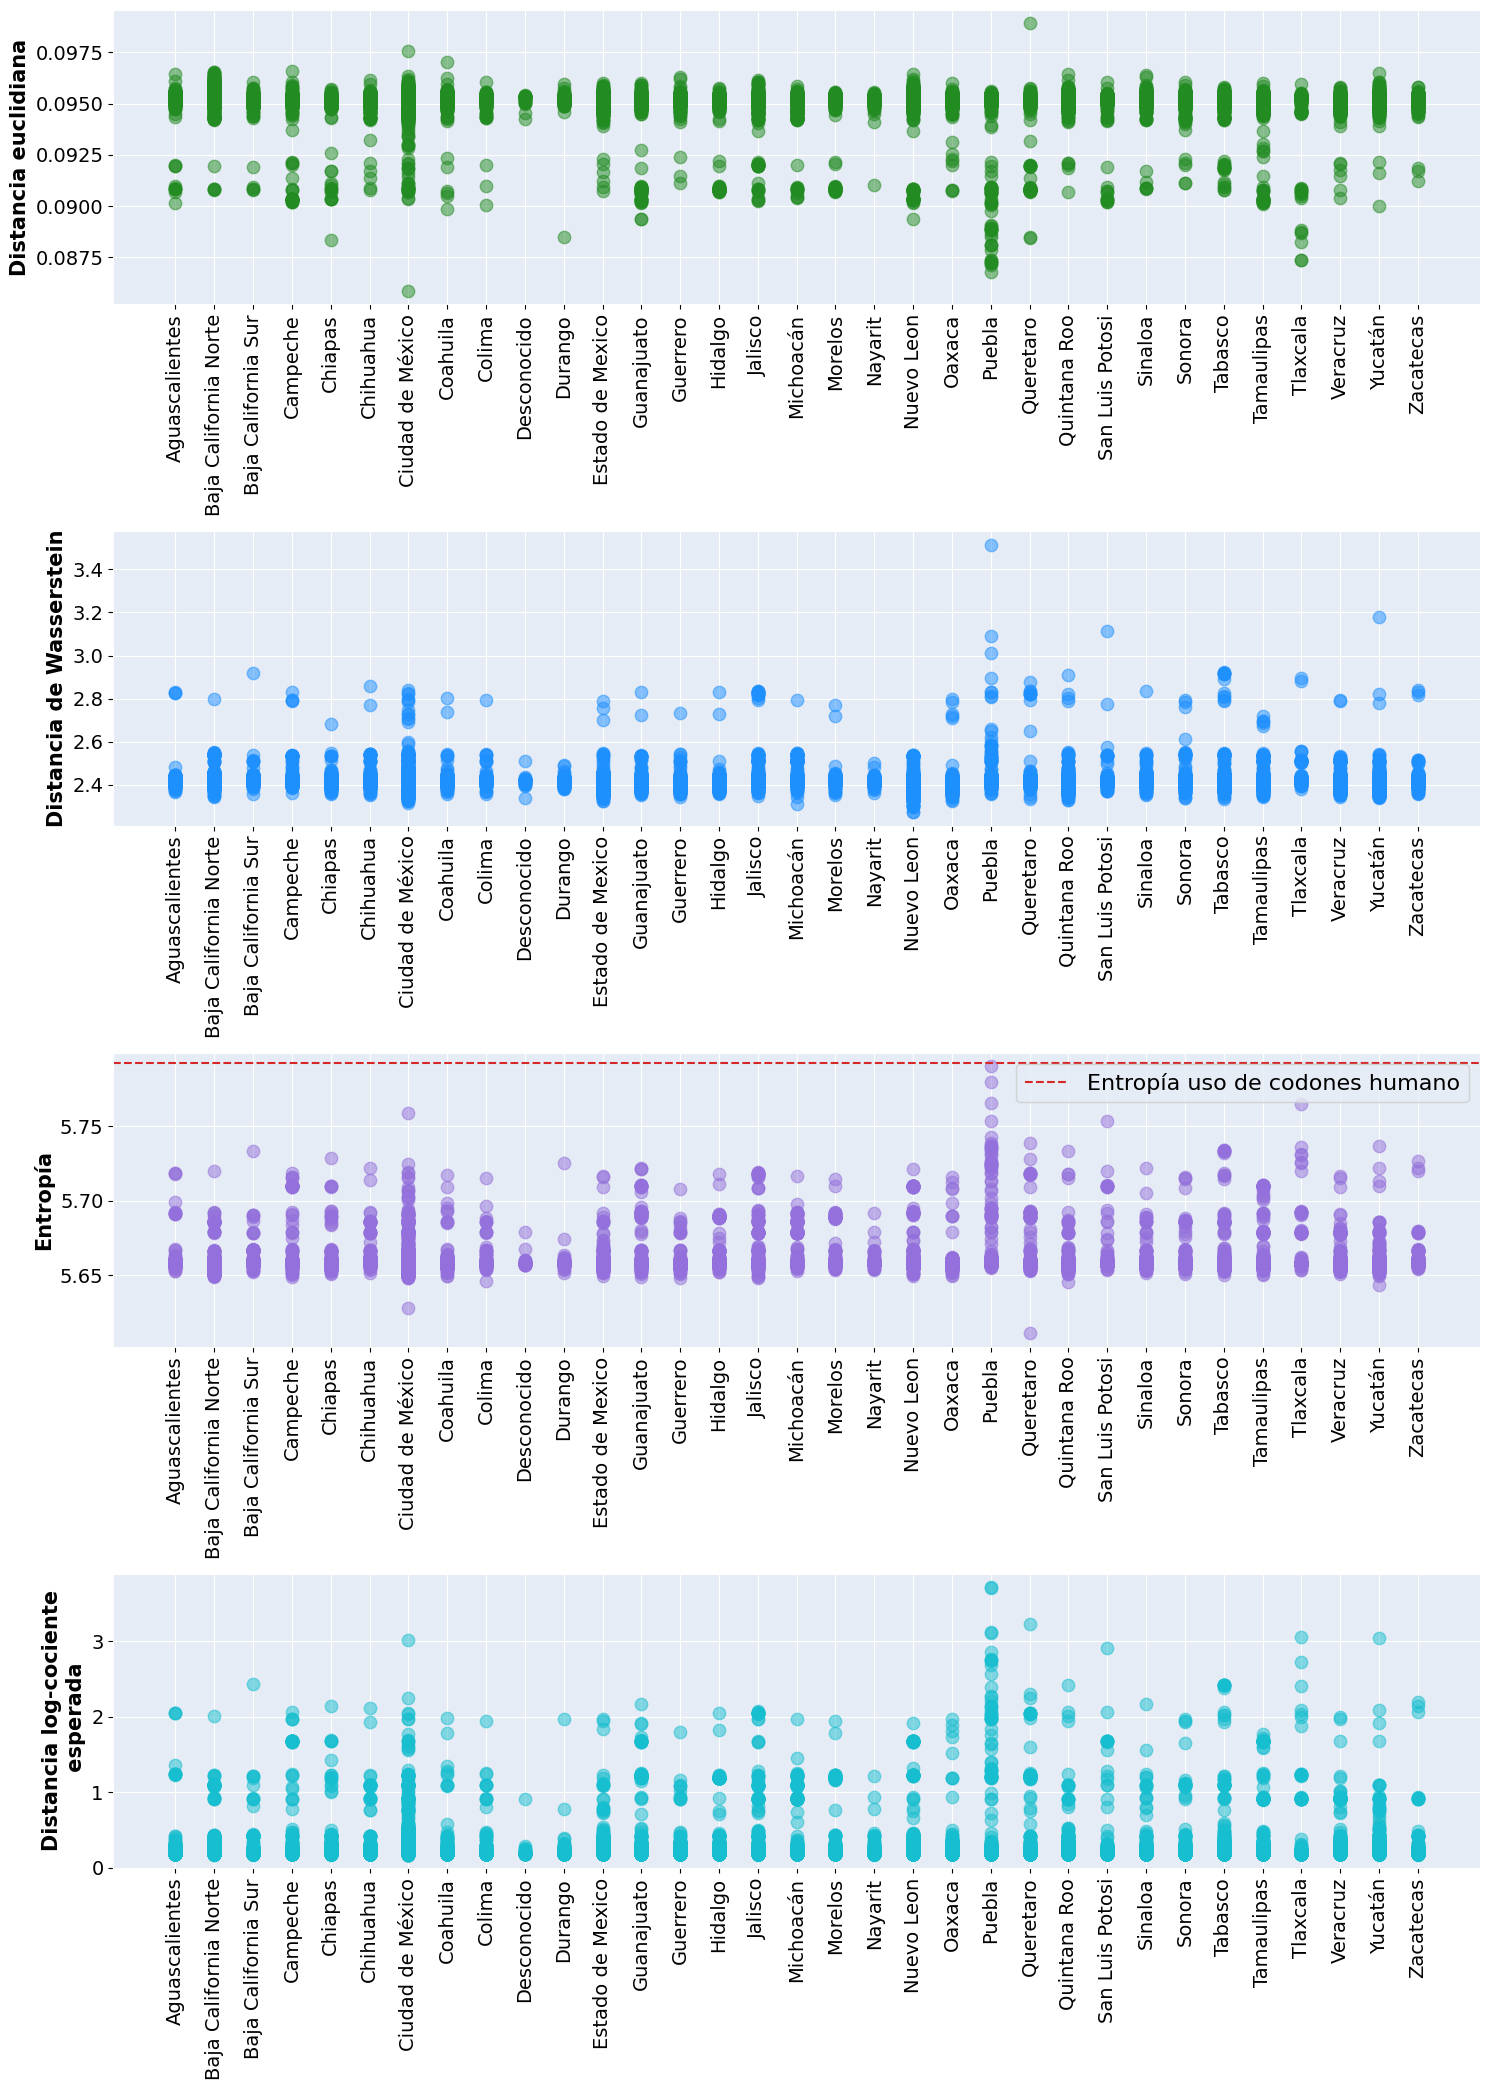

In [10]:
fig, axes = plt.subplot_mosaic(mosaic='A;B;C;D', figsize=(15,21), tight_layout=True)
plot_state(data=stats.sort_values(by='State'), y='Human_Euclidean', ylabel='Distancia euclidiana', 
           color='forestgreen', ax=axes['A'], title='')
plot_state(data=stats.sort_values(by='State'), y='Human_Wasserstein', ylabel='Distancia de Wasserstein', 
           color='dodgerblue', ax=axes['B'], title='')
plot_state(data=stats.sort_values(by='State'), y='Entropy', ylabel='Entropía', 
           color='mediumpurple', ax=axes['C'], title='')
axes['C'].axhline(humanEntropy, color='tab:red', linestyle='--', label='Entropía uso de codones humano');
axes['C'].legend(fontsize=16);
plot_state(data=stats.sort_values(by='State'), y='Mean_Logratio_dist', ylabel='Distancia log-cociente\n esperada',  
           color='tab:cyan', ax=axes['D'], title='')
fig.savefig('Images/distance_entropy_by_state.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig('Images(jpg)/distance_entropy_by_state.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

### • Usos de codones más divergentes agrupados por estado.

Adicionalmente, empleando la visualización de estos datos de la figura anterior, se seleccionaron los 50 genomas con los valores más divergentes de cada medida, y luego se formó la siguiente figura con el conteo de los mismos según su estado de procedencia.

In [11]:
def plot_data_by_state(*, data, color, title, ax):
    bar = (
        data['State']
        .value_counts()
        .plot.bar(color=color, xlabel='State', ylabel='Virus Count', ax=ax, fontsize=14)
    )
    ax.tick_params(axis='y', labelsize=14)
    ax.set_title(title, pad=10, fontdict=dict(size=16,weight='bold'));
    ax.bar_label(bar.containers[0], color='darkolivegreen', size=12);
    ax.set_xlabel('', fontdict=dict(size=15, weight='bold'))
    ax.set_ylabel('Virus', fontdict=dict(size=15, weight='bold'))

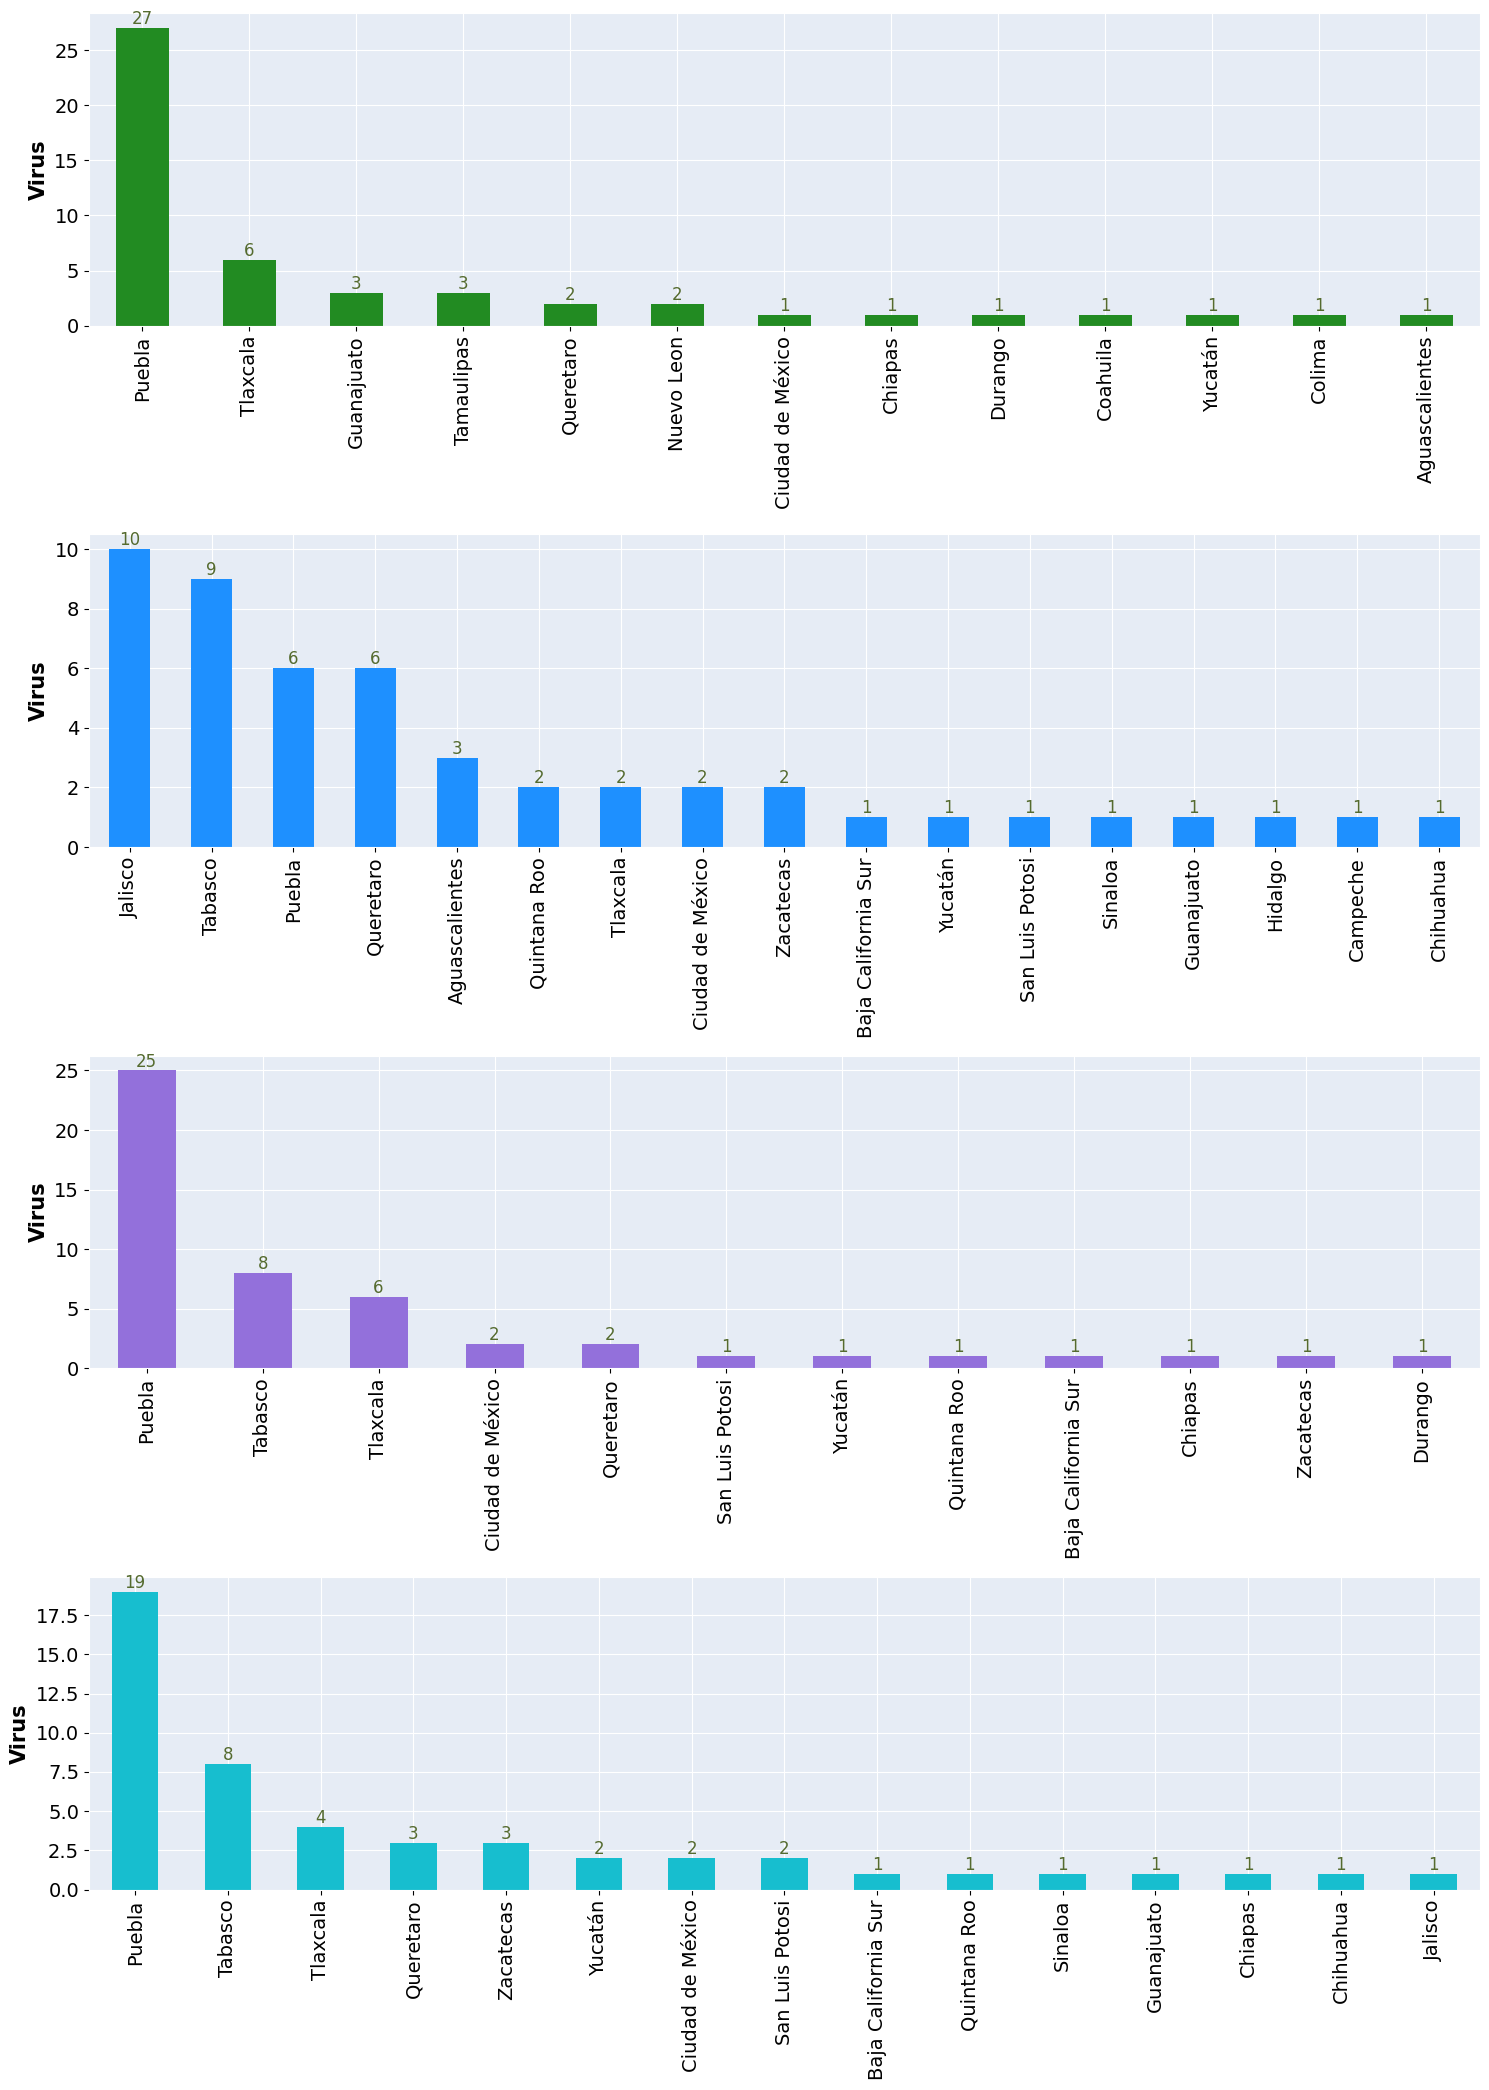

In [12]:
fig, axes = plt.subplot_mosaic(mosaic='A;B;C;D', figsize=(15,21), tight_layout=True)
top = 50

data = stats.nsmallest(top, 'Human_Euclidean')
plot_data_by_state(data=data, color='forestgreen', title='', ax=axes['A'])

data = stats.nlargest(top, 'Human_Wasserstein')
plot_data_by_state(data=data, color='dodgerblue', title='', ax=axes['B'])

data = stats.nlargest(top, 'Entropy')
plot_data_by_state(data=data, color='mediumpurple', title='', ax=axes['C'])

data = stats.nlargest(top, 'Mean_Logratio_dist')
plot_data_by_state(data=data, color='tab:cyan', title='', ax=axes['D'])

fig.savefig('Images/divergent_codon_usages_by_state.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig('Images(jpg)/divergent_codon_usages_by_state.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

### • Medidas sobre el uso de codones promedio por estado

Para obtener una perspectiva más general de las diferencias por estado, se procedió a calcular el uso de codones promedio correspondiente a cada uno de ellos. Para esto, inicialmente se agruparon los genomas del dataframe por estado y luego se determinó el uso de codones promedio de cada grupo. Posteriormente, se calcularon las mismas medidas de distancia y entropía sobre este conjunto de genomas promedio por estado. Los resultados se presentan en la siguiente figura.

In [13]:
mean_cub_by_state =(
    dataset
    .groupby(by='State')
    .mean(numeric_only=True)
    [codons]
)
# Se calculan las medidas
data = mean_cub_by_state[codons]
mean_cub_by_state['Human_Euclidean'] = (data.apply(lambda row: euclidean(row,humanCodons), axis=1))
mean_cub_by_state['Human_Wasserstein'] = (data.apply(lambda row: wasserstein_distance(np.arange(64), np.arange(64), row,humanCodons), axis=1))
mean_cub_by_state['Entropy'] = entropy(data, base=2, axis=1)
# Se aplica la transformacion log-cociente al conjutno de datos y se calcula la distancia esperada
data_clr = clr_transform(data)
mean_cub_by_state['Mean_Logratio_dist'] =  cdist(data_clr,data_clr).mean(axis=1)
mean_cub_by_state = mean_cub_by_state.reset_index()
mean_cub_by_state

,State,0,1,2,3,...,63,Human_Euclidean,Human_Wasserstein,Entropy,Mean_Logratio_dist
0,Aguascalientes,0.036098,0.017707,0.020510,0.034149,...,0.033741,0.095174,2.420471,5.659161,0.056296
1,Baja California Norte,0.036023,0.017657,0.020469,0.034226,...,0.033853,0.095275,2.424658,5.658540,0.061629
2,Baja California Sur,0.036094,0.017647,0.020521,0.034216,...,0.033853,0.095223,2.423690,5.659205,0.057756
...,...,...,...,...,...,...,...,...,...,...,...
30,Veracruz,0.036157,0.017686,0.020488,0.034055,...,0.033649,0.095160,2.418011,5.659278,0.051048
31,Yucatán,0.036181,0.017693,0.020532,0.034097,...,0.033755,0.095220,2.418829,5.658464,0.061166
32,Zacatecas,0.036115,0.017661,0.020487,0.034159,...,0.033776,0.095209,2.422286,5.659163,0.048410


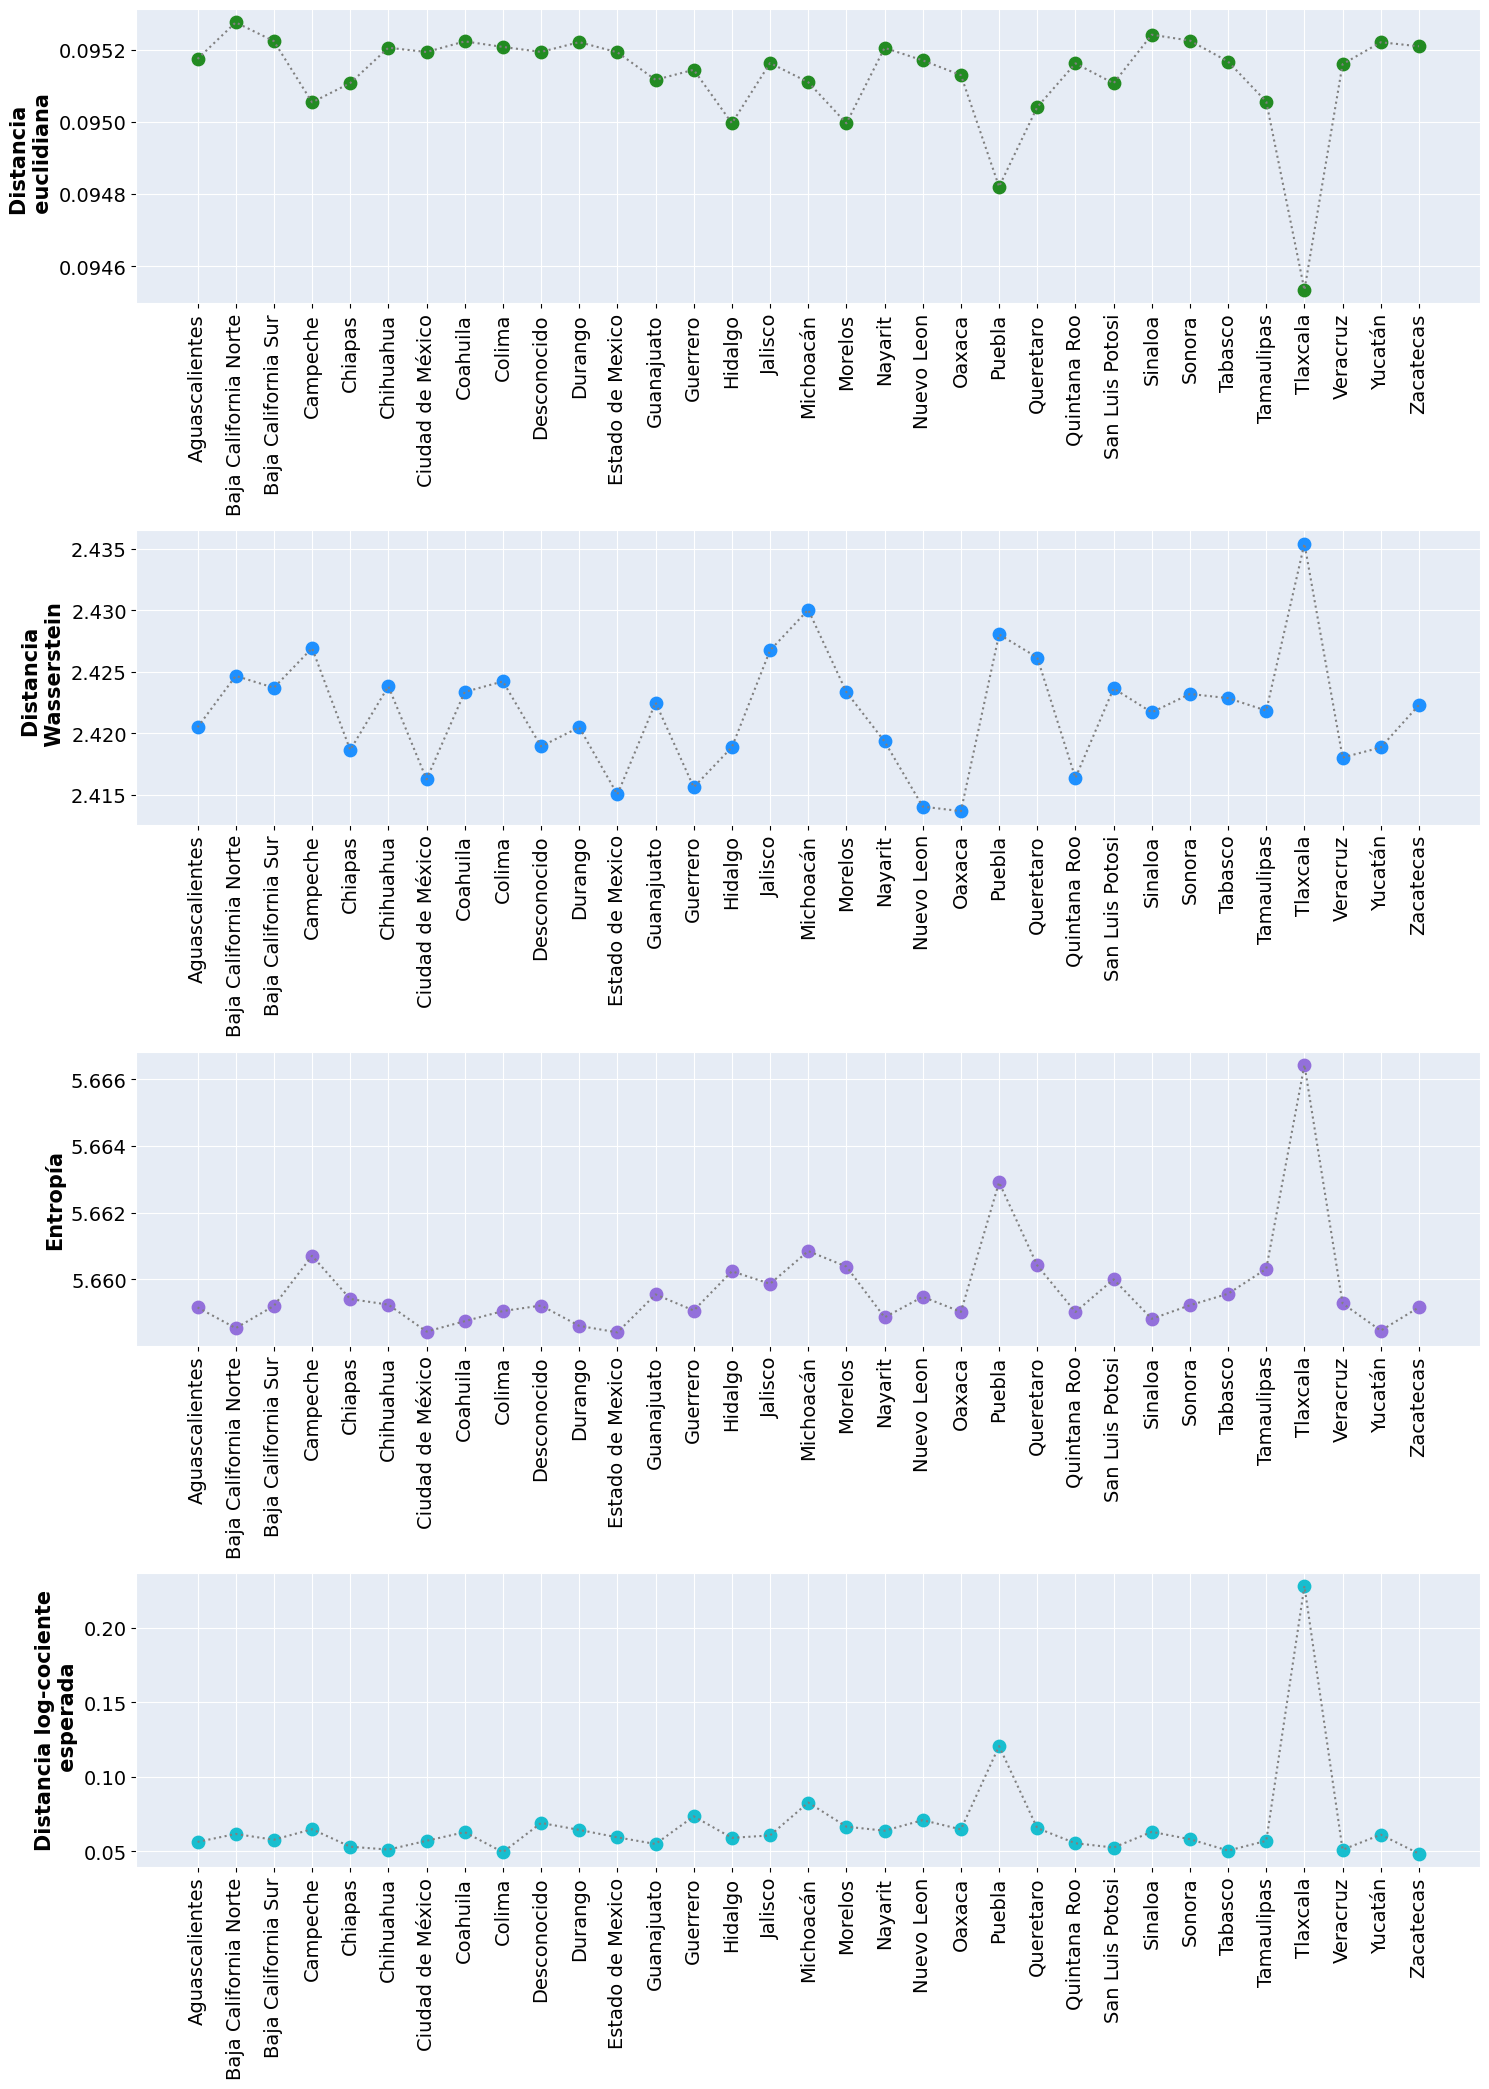

In [14]:
fig, axes = plt.subplot_mosaic(mosaic='A;B;C;D', figsize=(15,21), tight_layout=True)

axes['A'].plot(mean_cub_by_state['State'], mean_cub_by_state['Human_Euclidean'], linestyle=':', color='gray')
axes['A'].scatter(mean_cub_by_state['State'], mean_cub_by_state['Human_Euclidean'], color='forestgreen', s=80)
axes['A'].tick_params(axis='x', rotation=90, labelsize=14)
axes['A'].tick_params(axis='y', labelsize=14)
axes['A'].set_ylabel('Distancia \n euclidiana', fontdict=dict(size=15, weight='bold'))

axes['B'].plot(mean_cub_by_state['State'], mean_cub_by_state['Human_Wasserstein'], linestyle=':', color='gray')
axes['B'].scatter(mean_cub_by_state['State'], mean_cub_by_state['Human_Wasserstein'], color='dodgerblue', s=80)
axes['B'].tick_params(axis='x', rotation=90, labelsize=14)
axes['B'].tick_params(axis='y', labelsize=14)
axes['B'].set_ylabel('Distancia \n Wasserstein', fontdict=dict(size=15, weight='bold'))

axes['C'].plot(mean_cub_by_state['State'], mean_cub_by_state['Entropy'], linestyle=':', color='gray')
axes['C'].scatter(mean_cub_by_state['State'], mean_cub_by_state['Entropy'], color='mediumpurple', s=80)
axes['C'].tick_params(axis='x', rotation=90, labelsize=14)
axes['C'].tick_params(axis='y', labelsize=14)
axes['C'].set_ylabel('Entropía', fontdict=dict(size=15, weight='bold'))

axes['D'].plot(mean_cub_by_state['State'], mean_cub_by_state['Mean_Logratio_dist'], linestyle=':', color='gray')
axes['D'].scatter(mean_cub_by_state['State'], mean_cub_by_state['Mean_Logratio_dist'], color='tab:cyan', s=80)
axes['D'].tick_params(axis='x', rotation=90, labelsize=14)
axes['D'].tick_params(axis='y', labelsize=14)
axes['D'].set_ylabel('Distancia log-cociente\n esperada', fontdict=dict(size=15, weight='bold'));
fig.savefig('Images/distance_entropy_mean_codon_usage_by_state.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig('Images(jpg)/distance_entropy_mean_codon_usage_by_state.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

---

## ➤ Evolución Temporal

A fin de mostrar la evolución temporal de las medidas obtenidas, los resultados del dataframe se presentan organizados según su fecha de secuenciación. 

In [15]:
# Funcion para promediar los usos de codones por periodos de tiempo
def resample_data(dataset, *, by):
    dataset = (
        dataset
        .resample(by, on='Date')
        .mean(numeric_only=True)
        .dropna(axis=0)
        [codons]
    )
    # Se calculan las medidas
    data = dataset[codons]
    dataset['Human_Euclidean'] = (data.apply(lambda row: euclidean(row,humanCodons), axis=1))
    dataset['Human_Wasserstein'] = (data.apply(lambda row: wasserstein_distance(np.arange(64), np.arange(64), row,humanCodons), axis=1))
    dataset['Entropy'] = entropy(data, base=2, axis=1)
    # Se aplica la transformacion log-cociente al conjutno de datos y se calcula la distancia esperada
    data_clr = clr_transform(data)
    dataset['Mean_Logratio_dist'] =  cdist(data_clr,data_clr).mean(axis=1)
    dataset = dataset.reset_index()
    return dataset

In [16]:
# Funcion para graficar las medidas de uso de codones por fecha
def plot_time_series(data, *, column, color, ylabel, alpha, ax, line=False):
    x = data['Date']
    y = data[column]
    ax.scatter(x=x, y=y, color=color, s=40,  alpha=alpha, zorder=1);
    if line:
        ax.plot(x,y, linestyle=':', color='gray', alpha=0.6)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylabel(ylabel, fontdict=dict(size=15, weight='bold'))

Uso de codones promedidado por día

In [17]:
mean_cub_by_day = resample_data(dataset, by='D')
mean_cub_by_day

,Date,0,1,2,3,...,63,Human_Euclidean,Human_Wasserstein,Entropy,Mean_Logratio_dist
0,2020-01-01,0.035841,0.017684,0.020514,0.034291,...,0.033786,0.095272,2.421683,5.657751,0.115076
1,2020-02-27,0.035963,0.017780,0.020507,0.034246,...,0.033741,0.095212,2.415302,5.658038,0.112067
2,2020-02-28,0.035963,0.017780,0.020507,0.034246,...,0.033741,0.095212,2.415302,5.658038,0.112067
...,...,...,...,...,...,...,...,...,...,...,...
814,2022-06-14,0.036247,0.017666,0.020627,0.034213,...,0.034094,0.095458,2.438994,5.656047,0.195453
815,2022-06-15,0.036265,0.017663,0.020605,0.034192,...,0.034034,0.095443,2.439006,5.656206,0.198100
816,2022-06-16,0.036319,0.017704,0.020638,0.034043,...,0.034094,0.095336,2.428516,5.657282,0.203519


Uso de codones proomediado por semana

In [18]:
mean_cub_by_week = resample_data(dataset, by='W')
mean_cub_by_week

,Date,0,1,2,3,...,63,Human_Euclidean,Human_Wasserstein,Entropy,Mean_Logratio_dist
0,2020-01-05,0.035841,0.017684,0.020514,0.034291,...,0.033786,0.095272,2.421683,5.657751,0.103808
1,2020-03-01,0.035963,0.017780,0.020507,0.034246,...,0.033741,0.095212,2.415302,5.658038,0.101925
2,2020-03-08,0.035862,0.017679,0.020507,0.034246,...,0.033640,0.095173,2.413584,5.658135,0.121369
...,...,...,...,...,...,...,...,...,...,...,...
119,2022-06-05,0.036281,0.017628,0.020625,0.034116,...,0.034131,0.095402,2.434533,5.656897,0.192085
120,2022-06-12,0.036253,0.017642,0.020626,0.034152,...,0.034139,0.095457,2.441726,5.656299,0.193943
121,2022-06-19,0.036264,0.017663,0.020627,0.034201,...,0.034089,0.095459,2.439031,5.656014,0.192592


### • Medidas por fecha de secuenciacion

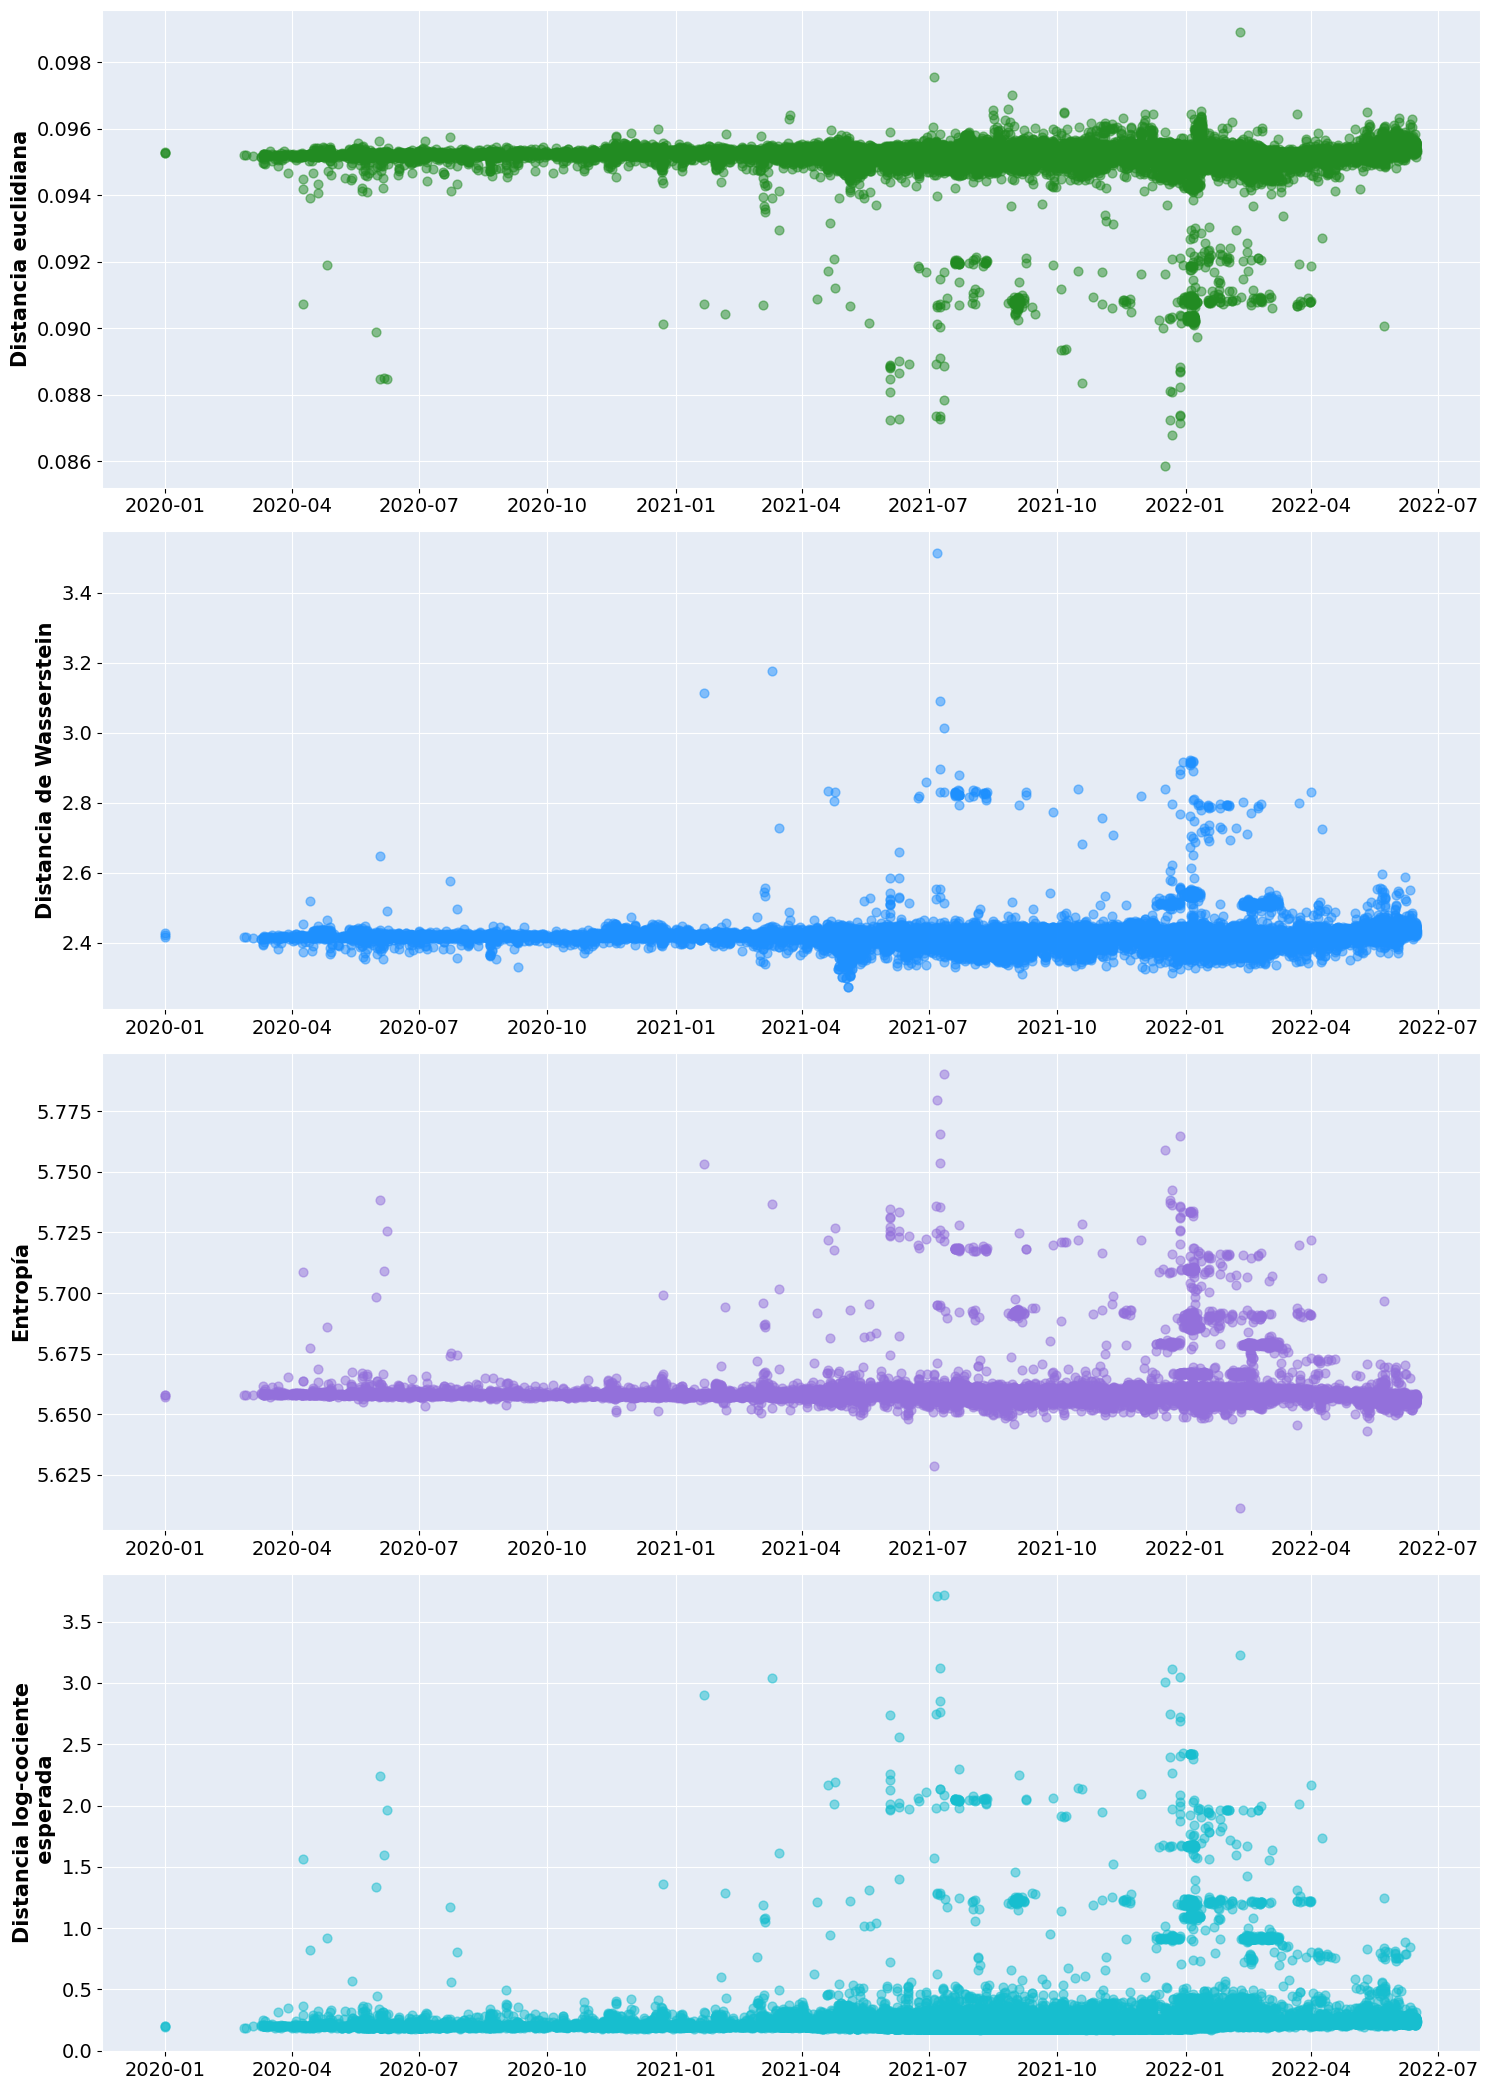

In [19]:
fig, axes = plt.subplot_mosaic(mosaic='A;B;C;D', figsize=(15,21), tight_layout=True)
plot_time_series(stats, column='Human_Euclidean', color='forestgreen', ylabel='Distancia euclidiana', alpha=0.5, ax=axes['A'], line=False)
plot_time_series(stats, column='Human_Wasserstein', color='dodgerblue', ylabel='Distancia de Wasserstein', alpha=0.5, ax=axes['B'], line=False)
plot_time_series(stats, column='Entropy', color='mediumpurple', ylabel='Entropía', alpha=0.5, ax=axes['C'], line=False)
plot_time_series(stats, column='Mean_Logratio_dist', color='tab:cyan', ylabel='Distancia log-cociente\n esperada', alpha=0.5, ax=axes['D'], line=False)
fig.savefig('Images/distance_entropy_by_date.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig('Images(jpg)/distance_entropy_by_date.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

Con el fin de estudiar la tendencia general que tienen los resultados a medida que pasa el tiempo, se calcularon los usos de codones representativos de cada día y cada semana. Como se muestra en las siguientes dos figuras.

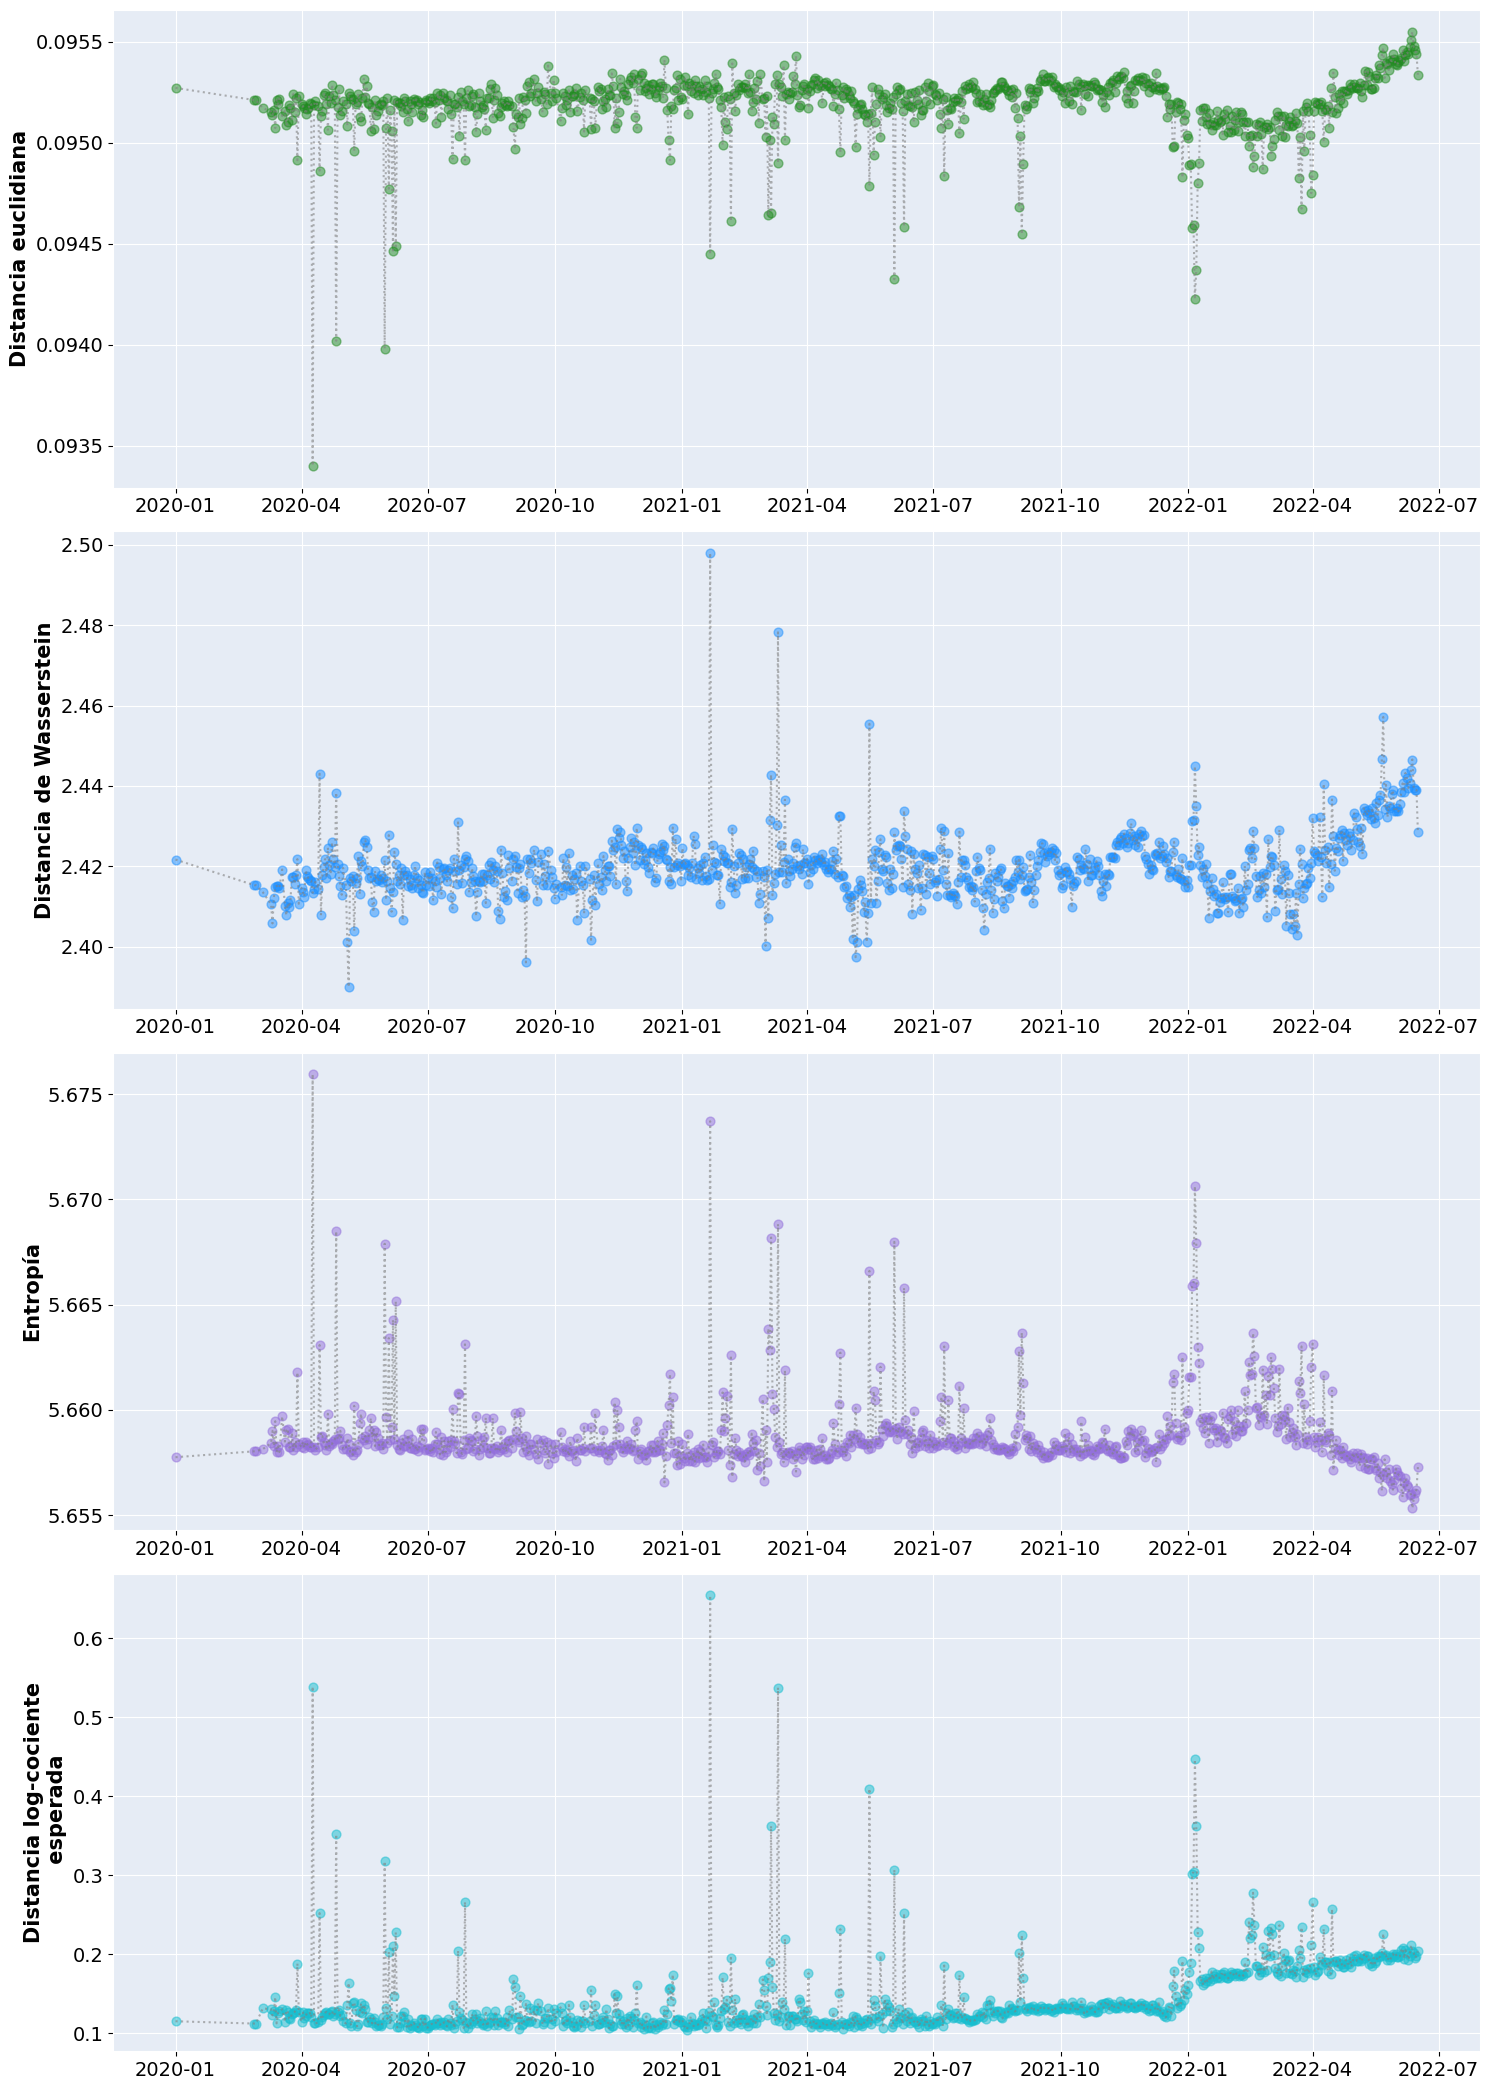

In [20]:
fig, axes = plt.subplot_mosaic(mosaic='A;B;C;D', figsize=(15,21), tight_layout=True)
plot_time_series(mean_cub_by_day, column='Human_Euclidean', color='forestgreen', ylabel='Distancia euclidiana', alpha=0.5, ax=axes['A'], line=True)
plot_time_series(mean_cub_by_day, column='Human_Wasserstein', color='dodgerblue', ylabel='Distancia de Wasserstein', alpha=0.5, ax=axes['B'], line=True)
plot_time_series(mean_cub_by_day, column='Entropy', color='mediumpurple', ylabel='Entropía', alpha=0.5, ax=axes['C'], line=True)
plot_time_series(mean_cub_by_day, column='Mean_Logratio_dist', color='tab:cyan', ylabel='Distancia log-cociente\n esperada', alpha=0.5, ax=axes['D'], line=True)
fig.savefig('Images/distance_entropy_mean_codon_usage_by_day.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig('Images(jpg)/distance_entropy_mean_codon_usage_by_day.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

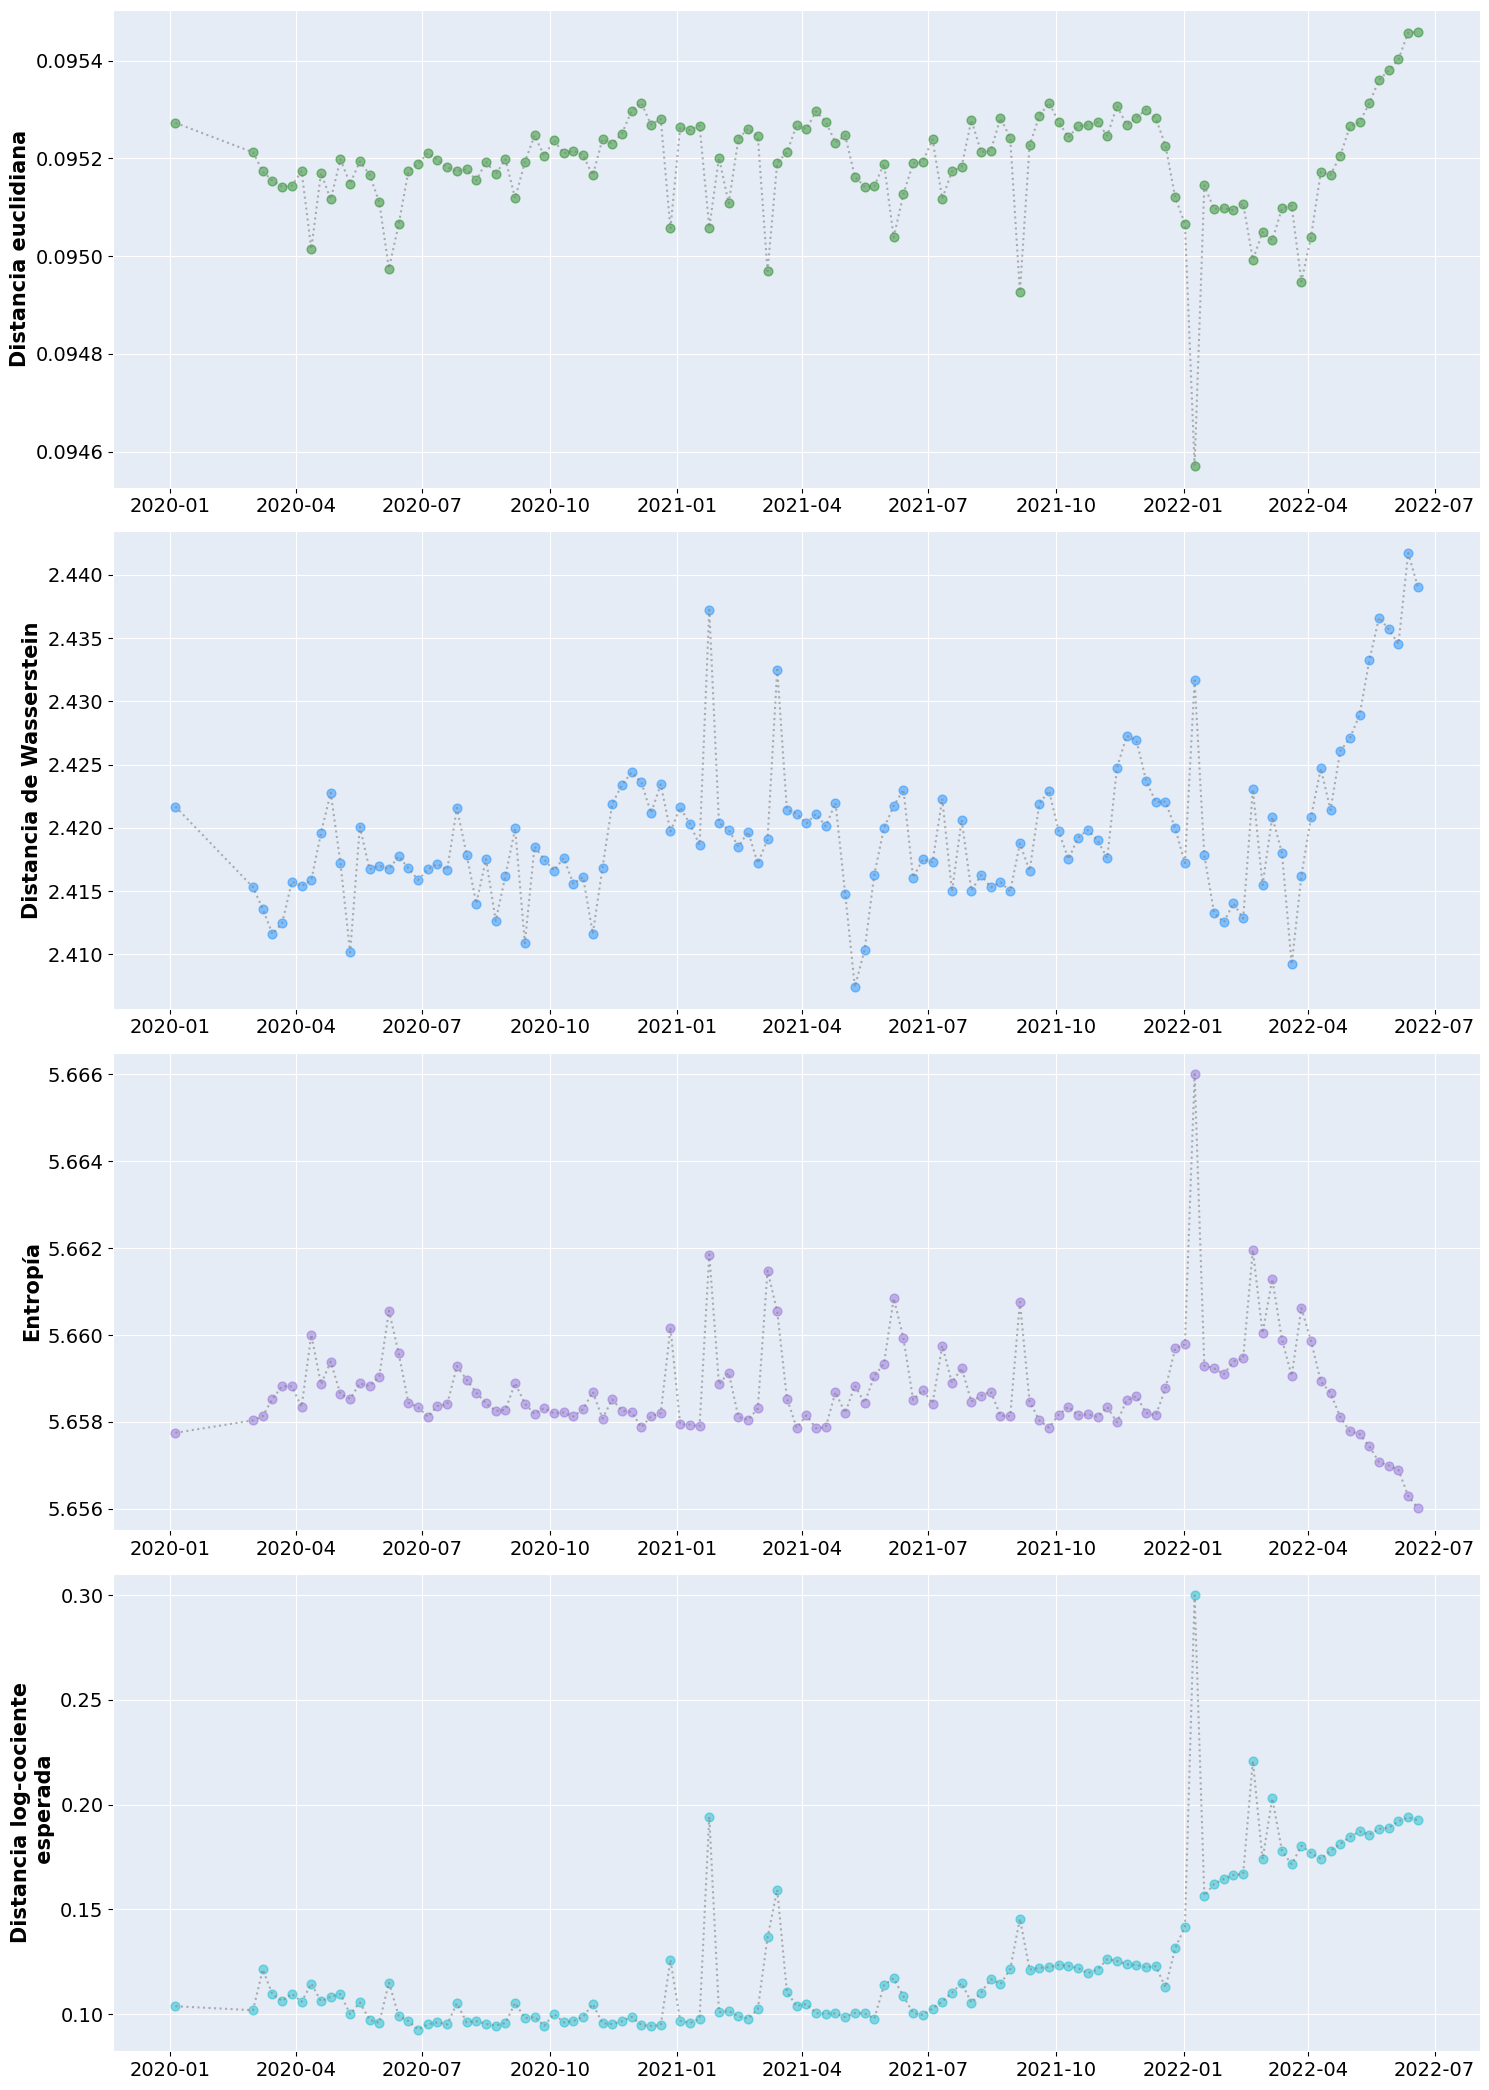

In [21]:
fig, axes = plt.subplot_mosaic(mosaic='A;B;C;D', figsize=(15,21), tight_layout=True)
plot_time_series(mean_cub_by_week, column='Human_Euclidean', color='forestgreen', ylabel='Distancia euclidiana', alpha=0.5, ax=axes['A'], line=True)
plot_time_series(mean_cub_by_week, column='Human_Wasserstein', color='dodgerblue', ylabel='Distancia de Wasserstein', alpha=0.5, ax=axes['B'], line=True)
plot_time_series(mean_cub_by_week, column='Entropy', color='mediumpurple', ylabel='Entropía', alpha=0.5, ax=axes['C'], line=True)
plot_time_series(mean_cub_by_week, column='Mean_Logratio_dist', color='tab:cyan', ylabel='Distancia log-cociente\n esperada', alpha=0.5, ax=axes['D'], line=True)
fig.savefig('Images/distance_entropy_mean_codon_usage_by_week.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig('Images(jpg)/distance_entropy_mean_codon_usage_by_week.jpg', dpi=1000, bbox_inches='tight', facecolor='none')

---

## ➤ Distancias contra entropía

Con el propósito de analizar la correlación existente entre las medidas computadas, se realizó una gráfica de dispersión entre cada una de las distancias y la entropía. La siguiente figura muestra los resultados obtenidos. 

In [7]:
def plot_scatterplot_corr(data, *, x, y, color, xlabel, ylabel, ax):
    # Plot the relation between the euclidean distance and the entropy, and compute the pearson's correlation
    stats.plot.scatter(x=x, y=y, color=color, alpha=0.5, linewidths=0, edgecolors='white', s=80, ax=ax, fontsize=14, linewidth=0.4)
    ax.set_xlabel(xlabel, fontdict=dict(size=15, weight='bold'))
    ax.set_ylabel(ylabel, fontdict=dict(size=15, weight='bold'))
    coor_pearson = pearsonr(data[x],data[y]).statistic
    ax.legend([f'Correlación de pearson = {coor_pearson:.4f}'],markerscale=0, markerfirst=False, 
              handlelength=0, prop=dict(size=14,weight='medium'), loc='upper left');

### • Gráficas de dispersión y correlación

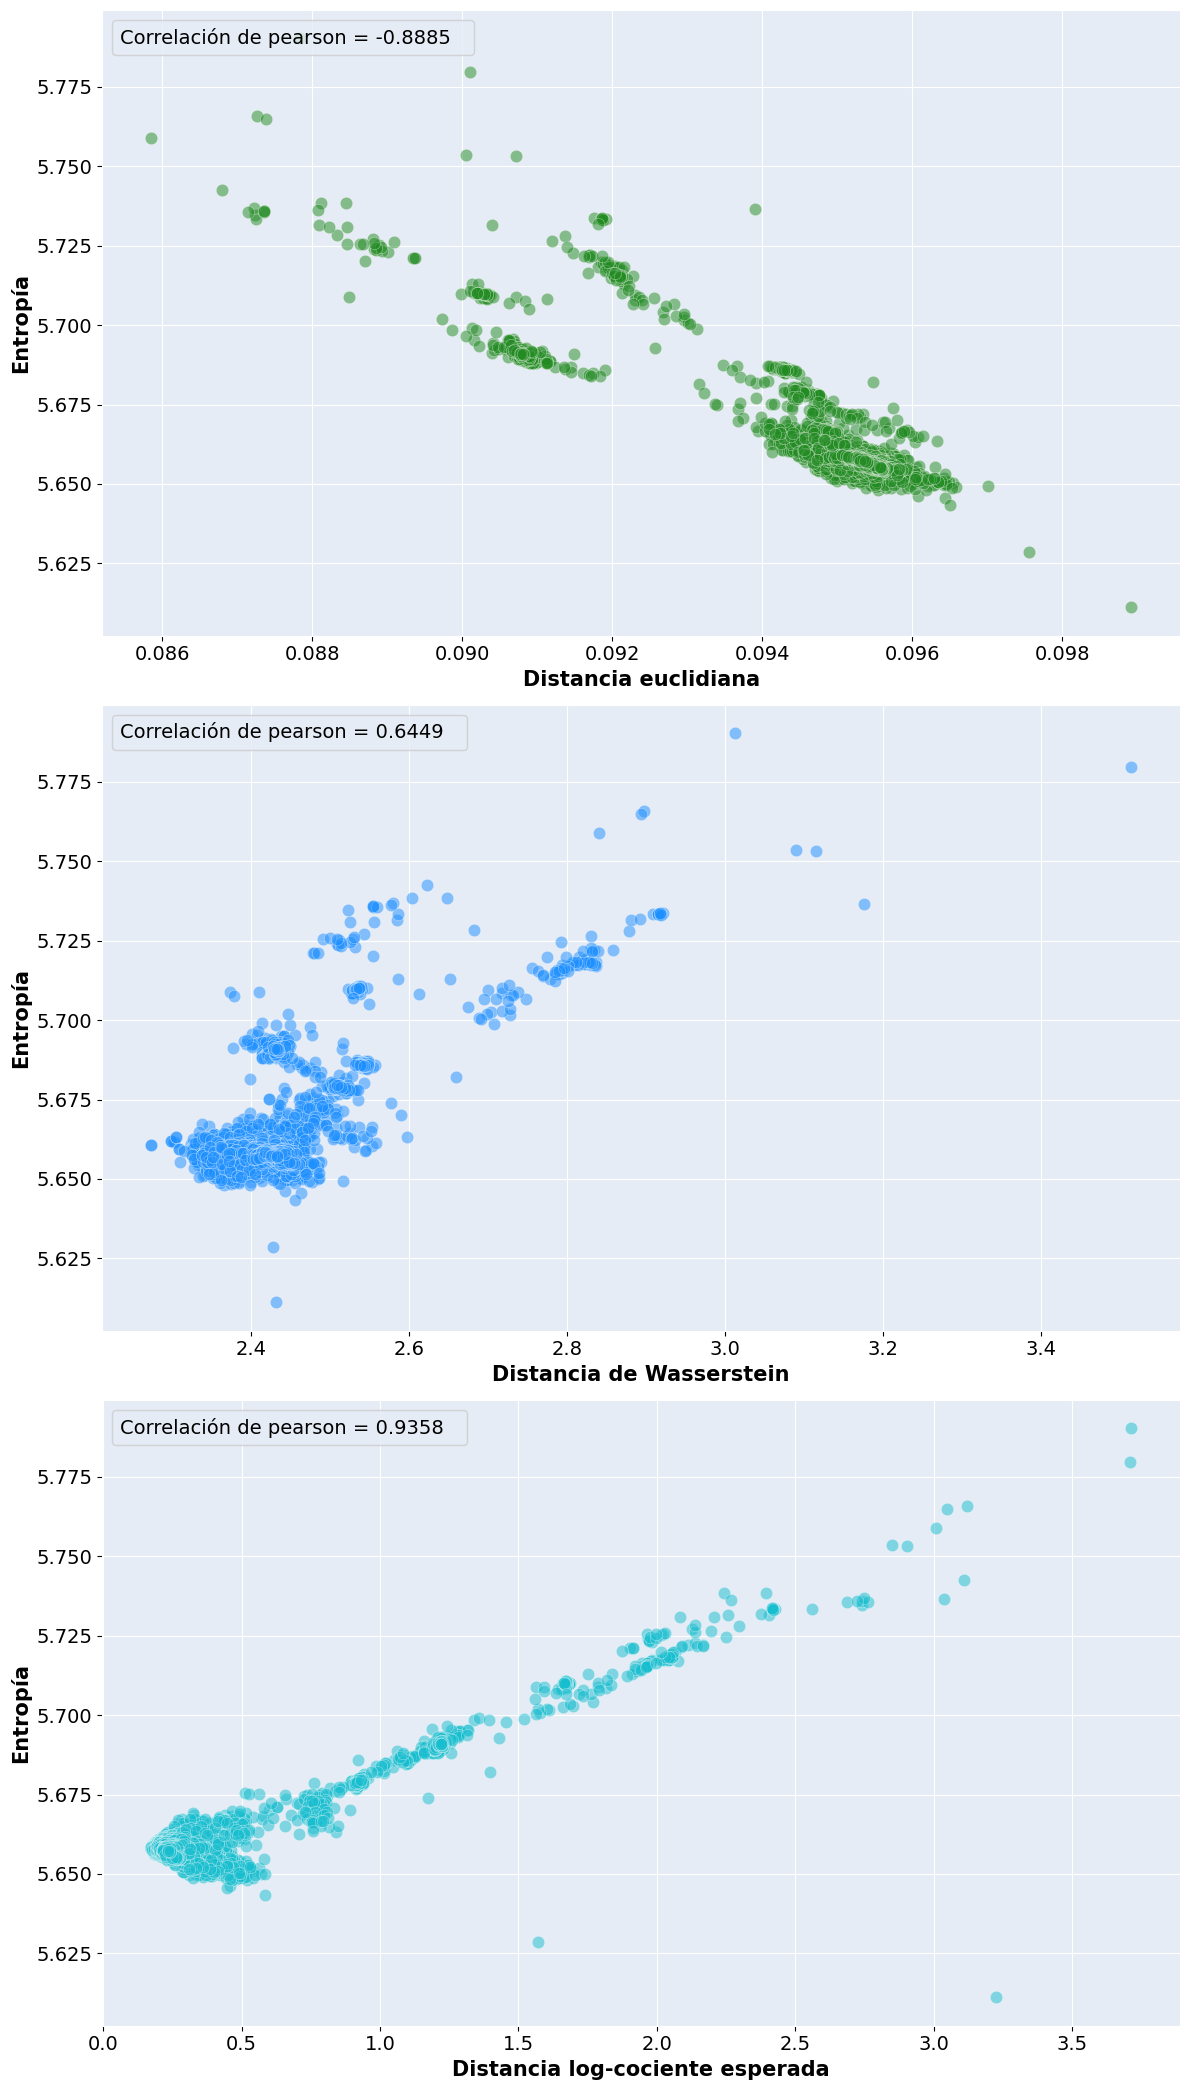

In [8]:
fig, axes = plt.subplot_mosaic(mosaic='A;B;C', figsize=(12,21), tight_layout=True)
plot_scatterplot_corr(stats, x='Human_Euclidean', y='Entropy', color='forestgreen', xlabel='Distancia euclidiana', ylabel='Entropía', ax=axes['A'])
plot_scatterplot_corr(stats, x='Human_Wasserstein', y='Entropy', color='dodgerblue', xlabel='Distancia de Wasserstein', ylabel='Entropía', ax=axes['B'])
plot_scatterplot_corr(stats, x='Mean_Logratio_dist', y='Entropy', color='tab:cyan', xlabel='Distancia log-cociente esperada', ylabel='Entropía', ax=axes['C'])
fig.savefig('Images/distances_vs_entropy.pdf', dpi=1000, bbox_inches='tight', facecolor='none')
fig.savefig('Images(jpg)/distances_vs_entropy.jpg', dpi=1000, bbox_inches='tight', facecolor='none')